<a href="https://colab.research.google.com/github/yashika-git/NLP/blob/main/Review_Based_QA_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# References:
# Book: Natural Language Processing with Transformers and accompanying code: https://github.com/nlp-with-transformers/notebooks/blob/main/07_question-answering.ipynb

In [64]:
# Work in progress

In [65]:
!pip -q install transformers
!pip -q install datasets

In [66]:
from datasets import get_dataset_config_names
import matplotlib.pyplot as plt

In [67]:
domains = get_dataset_config_names('subjqa') # To find out the subsets of dataset
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [68]:
# We'll be focussing on 'electronics' domain
from datasets import load_dataset
subjqa = load_dataset('subjqa', name='electronics')

WARNING - datasets.builder -  Reusing dataset subjqa (/root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [69]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [70]:
# Flattening the nested columns with 'flatten' and converting the dataset to a pandas dataframe
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [71]:
dfs['train'].head()

,domain,nn_mod,nn_asp,query_mod,query_asp,q_reviews_id,question_subj_level,ques_subj_score,is_ques_subjective,review_id,id,title,context,question,answers.text,answers.answer_start,answers.answer_subj_level,answers.ans_subj_score,answers.is_ans_subjective
0,electronics,great,bass response,excellent,bass,0514ee34b672623dff659334a25b599b,5,0.50,False,882b1e2745a4779c8f17b3d4406b91c7,2543d296da9766d8d17d040ecc781699,B00001P4ZH,"I have had Koss headphones in the past, Pro 4AA and QZ-99. The Koss Portapr...",How is the bass?,[],[],[],[],[]
1,electronics,harsh,high,not strong,bass,7c46670208f7bf5497480fbdbb44561a,1,0.50,False,ce76793f036494eabe07b33a9a67288a,d476830bf9282e2b9033e2bb44bbb995,B00001P4ZH,"To anyone who hasn't tried all the various types of headphones, it is import...",Is this music song have a goo bass?,"[Bass is weak as expected, Bass is weak as expected, even with EQ adjusted up]","[1302, 1302]","[1, 1]","[0.5083333, 0.5083333]","[True, True]"
2,electronics,neutral,sound,present,bass,8fbf26792c438aa83178c2d507af5d77,1,0.50,False,d040f2713caa2aff0ce95affb40e12c2,455575557886d6dfeea5aa19577e5de4,B00001P4ZH,"I have had many sub-$100 headphones from $5 Panasonic to $100 Sony, with Sen...",How is the bass?,[The only fault in the sound is the bass],[650],[2],[0.6333333],[True]
3,electronics,muddy,bass,awesome,bass,9876fd06ed8f075fcad70d1e30e7e8be,1,0.50,False,043e7162df91f6ea916c790c8a6f6b22,6895a59b470d8feee0f39da6c53a92e5,B00001WRSJ,"My sister's Bose headphones finally died and so, her being a super audiophil...",How is the audio bass?,[the best of all of them],[1609],[1],[0.3],[False]
4,electronics,perfect,bass,incredible,sound,16506b53e2d4c2b6a65881d9462256c2,1,0.65,True,29ccd7e690050e2951be49289e915382,7a2173c502da97c5bd5950eae7cd7430,B00001WRSJ,Wow. Just wow. I'm a 22 yr old with a crazy obsession with sound and music. ...,Why do I have an incredible sound?,"[The sound is so crisp, crazy obsession with sound and music]","[141, 38]","[1, 1]","[0.40833333, 0.40833333]","[False, False]"


In [72]:
# Description of some relevant columns:

# title: The Amazon Standard Identification Number (ASIN) associated with each product
# question: The question
# answers.answer_text: The span of text in the review labeled by the annotator
# answers.answer_start: The start character index of the answer span
# context: The customer review

In [73]:
qa_cols = ['title', 'question', 'answers.text', 'answers.answer_start', 'context']
sample_df = dfs['train'][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 stars because it doesn't have a CA...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro battery I bought wouldn't hold a c...


In [74]:
# empty answers.text corresponds to the questions whose answers cannot be found in the reviews

In [75]:
# slicing out the span of the text in the review that correspond to the answer

#start_idx = sample_df["answers.answer_start"].iloc[0] returns an array, so we will index at 0 again
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
# sample_df["context"].iloc[0] returns the whole context
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

{'What': 236, 'How': 780, 'Is': 100, 'Does': 45, 'Do': 83, 'Was': 12, 'Where': 28, 'Why': 21}


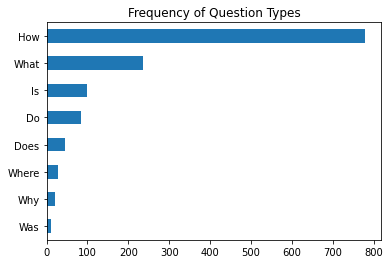

In [76]:
# counting the questions that begin with a few common starting words
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
print(counts)
pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()  

In [77]:
# Looking at some questions beginning with "How", "What" and "Is"
# for question_type in ["How", "What", "Is"]:
# for question in (
# dfs["train"][dfs["train"].question.str.startswith(question_type)]
# .sample(n=3, random_state=42)['question']):
# print(question)

for question_type in ["How", "What", "Is"]:
  for question in (dfs['train'][(dfs['train']['question'].str.startswith(question_type))].sample(n=2)['question']):
    print(question)

    


How is the image?
How is the earphone?
What do you think about clasp?
What are the sizes of the lens?
Is the focus ring smooth?
Is this one a good headphone choice?


In [78]:
# Extracting answers from text by framing the problem as a span classification task, where the start and end tokens of an
# answer span act as the labels that a model needs to predict.
# Using fine-tuned MiniLM Model, since it is fast to train

# 'Treating QA as token classification'

In [79]:
# Tokenizing text
from transformers import AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [80]:
# Trying to extract answer from a short passage
question = "How much music can this hold?"
context = "An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."
inputs = tokenizer(question, context, return_tensors="pt")

In [81]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

In [82]:
input_df = pd.DataFrame.from_dict(tokenizer(question), orient="index")
input_df

,0,1,2,3,4,5,6,7,8
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102
token_type_ids,0,0,0,0,0,0,0,0,0
attention_mask,1,1,1,1,1,1,1,1,1


In [83]:
input_df = pd.DataFrame.from_dict(tokenizer(context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
input_ids,101,2019,23378,2003,2055,1015,16914,1013,3371,1010,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
attention_mask,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [84]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df
# input_ids is the unique identifier for distinct tokens
# token_type_ids are 0 for question and 1 for context

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [85]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context))
input_df

,0
0,input_ids
1,token_type_ids
2,attention_mask


In [86]:
print(tokenizer.decode(inputs["input_ids"][0]))


[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]


In [87]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  outputs = model(**inputs)
print(outputs)  

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [88]:
# Getting the logits of start and end tokens
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [89]:
print(f"Input IDs shape: {inputs['input_ids'].size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


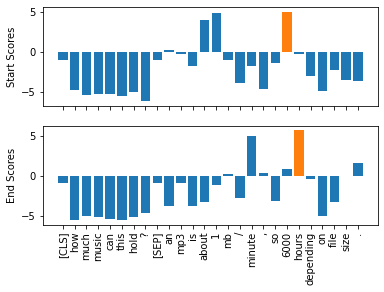

In [90]:
# Visualizing the logits

import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]) # [0] because list of tensors

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ['C0' if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else 'C1' for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [91]:
# '6000' has the highest logits for start token while 'hours' has the highest logits value for end token.

In [92]:
# In order to get the answer to the question, we scompute the argmax over the start and end token logits and then extract the span from the inputs.

import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) 
answer_span = inputs['input_ids'][0][start_idx:end_idx + 1]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [93]:
# Wrapping all the post-processing and pre-processing steps in a pipeline
from transformers import pipeline

pipe = pipeline('question-answering', model=model, tokenizer=tokenizer, handle_impossible_answer=True)
pipe(question=question, context=context, topk=3) #topk is the number of answers to return

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'answer': '6000 hours', 'end': 48, 'score': 0.2651623487472534, 'start': 38},
 {'answer': '1 MB/minute, so about 6000 hours',
  'end': 48,
  'score': 0.22082945704460144,
  'start': 16},
 {'answer': '1 MB/minute',
  'end': 27,
  'score': 0.10253474861383438,
  'start': 16}]

In [94]:
pipe(question="Why is there no data?", context=context)

{'answer': '', 'end': 0, 'score': 0.9068416357040405, 'start': 0}

In [95]:
pipe(question="Why is there no data?", context=context, handle_impossible_answer=True)

{'answer': '', 'end': 0, 'score': 0.9068416357040405, 'start': 0}

In [96]:
# Dealing with long passages
# Context size for MiniLM is 512.
# In classification tasks, the passage is truncated at 512, assuming enough information was contained in the 512 tokens.
# However, truncating may not work in QA because the answer could lie near to the end of the context

# The standard way to deal with this is applying sliding window across the inputs, where each window contains a passage of tokens that fit in model's context

In [97]:
# Hyperparameters for sliding window:
# return_overflowing_tokens (bool) enables sliding window
# max_seq_length: size of the sliding window
# doc_stride: size of the stride

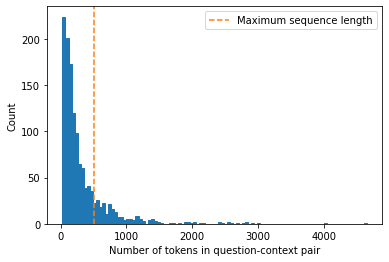

In [98]:
def compute_input_length(row):
  inputs = tokenizer(row['question'], row['context'])
  return len(inputs['input_ids'])

dfs['train']['n_tokens'] = dfs['train'].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs['train']['n_tokens'].hist(bins=100, grid=False, ec='C0', ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color='C1', label='Maximum sequence length')
plt.legend()
plt.ylabel('Count')
plt.show()  

In [99]:
example = dfs['train'].iloc[0][['question', 'context']]
tokenized_example = tokenizer(example['question'], example['context'], return_overflowing_tokens=True, max_length=100, stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [100]:
for idx, window in enumerate(tokenized_example['input_ids']):
  print(f"Window {idx} has {len(window)} tokens")

Window 0 has 100 tokens
Window 1 has 88 tokens


In [101]:
for window in tokenized_example['input_ids']:
  print(f'{tokenizer.decode(window)}\n')

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]



Using Haystack for building QA Pipeline


In [102]:
# For selecting relevant passage from all of the reviews, modern QA systems use retriever-reader architecture.

# Retriever: Responsible for retrieving relevant documents for agiven query. Can be sparse or dense. Sparseretrievers use word frequqency while dense retrievers use transformers.
# Reader: Responsible for extracting answers from the documents provided by the retriever.

# Documents retrieved by retriever may need some post-processing to filter out irrelevant documents. Post-processing of reader's answer may also be required if the answer comes from various passages.

# Haystack is a retriever-reader architecture based library developed by deepse, a German company.

# Other components involved when building a QA library with Haystack are:
# Document Store: A database of all the documents and metadata provided to the retriever
# Pipeline: Enables custom query flow by combining all then components of QA system

In [103]:
# Elasticsearch is a NoSQL database, it stores the data in document format.
url = """https://artifacts.elastic.co/downloads/elasticsearch/\elasticsearch-7.9.2-linux-x86_64.tar.gz"""
#nc command runs Netcat, a utility for sending raw data over a network connection
!wget -nc -q {url} 
#tar -xzf is just a method for extracting, -x = extract, -z = gzipped archive, -f = get from a file
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [104]:
import os
from subprocess import Popen, PIPE, STDOUT
# subprocesses module allows to spawn new processes. 
# Run Elasticsearch as a background process
# chown changes the owner, -R stands for recursive 
# Daemons are utility programs that run silently in the background to monitor and take care of certain subsystems to ensure that the operating system runs properly
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
stdout=PIPE, stderr=STDOUT, preexec_fn=lambda:
os.setuid(1))
#args specify the program we wish to execute,stdout=PIPE creates a new pipe for the standard output, stderr=STDOUT collects the errors in the same pipe
# preexec_fn argument specifies the ID of the subprocess we wish to use. 
# Wait until Elasticsearch has started
!sleep 30

In [105]:
# By default, Elasticsearch runs locally on port 9200, so we can test the connection by sending an HTTP request to localhost
# curl is used for transferring data to and from server
!curl -X GET "localhost:9200/?pretty"


{
  "name" : "0cb9d52dfb68",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "T4JzmphLTfyBousZEZ8fUw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [106]:
# !pip install torch==1.10.0+cu111 -f https://download.pytorch.org/whl/cu111/torch_stable.html
# !pip install git+https://github.com/deepset-ai/haystack.git



In [126]:
# from haystack.utils import clean_wiki_text, convert_files_to_docs, fetch_archive_from_http, print_answers
# from haystack.nodes import FARMReader, TransformersReader

In [118]:
# from haystack.document_stores import InMemoryDocumentStore
from haystack.document_stores.elasticsearch import ElasticsearchDocumentStore
document_store = ElasticsearchDocumentStore(return_embedding=True)


In [127]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"], 
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

TypeError: ignored

In [112]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_stores=document_store)

NameError: ignored

In [122]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [ ]:
print(retrieved_docs[0])


In [125]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/minilm-uncased-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/minilm-uncased-squad2
INFO - haystack.modeling.utils -  Using devices: CPU
INFO - haystack.modeling.utils -  Number of GPUs: 0
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0     0  
INFO - haystack.modeling.infer -  /w\   /w\ 
INFO - haystack.modeling.infer -  /'\   / \ 


In [124]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))


{'query': 'How much music can this hold?', 'no_ans_gap': 12.648081660270691, 'answers': [<Answer {'answer': '6000 hours', 'type': 'extractive', 'score': 0.5293052345514297, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours depending on file size.', 'offsets_in_document': [{'start': 38, 'end': 48}], 'offsets_in_context': [{'start': 38, 'end': 48}], 'document_id': 'e344757014e804eff50faa3ecf1c9c75', 'meta': {}}>]}


/usr/local/lib/python3.7/dist-packages/haystack/modeling/model/prediction_head.py:483: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
